In [1]:
import os
import argparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn

from monai.networks.nets import DenseNet121, resnet50, EfficientNetBN, SEResNet50, SENet154
from monai.transforms import *
from monai.utils import set_determinism

from ImageFolder import make_dataset
from dataset import MRIDataset
from EfficientNet import MyEfficientNet

import warnings
import pandas as pd
warnings.filterwarnings('ignore')

In [2]:
set_determinism(seed=2021)

In [3]:
parser = argparse.ArgumentParser(description='evaluated parameters')

parser.add_argument('--cuda', default='0', type=str, help='gpu id')
parser.add_argument('--dataroot', default='../data/MRISeq/0628split')
parser.add_argument('--classes', default='model/log/classes.csv', type=str)

parser.add_argument('--batch', default=32, type=int, help='batch size')
parser.add_argument('--stack', default=8, type=int, help='input channel')

parser.add_argument('--model', default='EfficientNet', help='choose model')
parser.add_argument('--save_path', default='../MRISeq_paper/Results/EfficientNet/20220809_stack8_lr1e-05_epochs100/')

args = parser.parse_args("")

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = args.cuda
extensions = ('.gz',)

In [5]:
## get all data
img_label_dict, imgs, labels, classes, class_to_idx = make_dataset(args.dataroot, extensions=extensions)

In [6]:
## get test dataset
X_train_val, X_test, y_train_val, y_test = train_test_split(imgs, labels, test_size=0.2, random_state=42,
                                                          stratify=labels)
# count the number of each class
testset = set(y_test)
test_count = {}
for cls in testset:
    test_count.update({cls: [y_test.count(cls), labels.count(cls)]})
print('number of test data/all data')
print(test_count)
print(f'number of total test data: {len(y_test)}')

# build train files and val files
test_data = []
for i, j in zip(X_test, y_test):
    test_data.append({'img': i, 'label': j})

number of test data/all data
{0: [39, 193], 1: [871, 4356], 2: [477, 2384], 3: [236, 1177], 4: [716, 3580], 5: [104, 522], 6: [90, 452], 7: [311, 1554], 8: [12, 62], 9: [880, 4398]}
number of total test data: 3736


In [7]:
## transform and data loader
val_transforms = Compose(
        [
            ScaleIntensityd(keys='img'),
            EnsureTyped(keys=['img', 'label'])
        ]
    )

test_ds = MRIDataset(data=test_data, stack=args.stack, transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=args.batch, num_workers=4, pin_memory=torch.cuda.is_available())

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
architecture = args.model
if architecture == 'resnet50':
    model = resnet50(spatial_dims=2, n_input_channels=args.stack, num_classes=len(classes),
                     pretrained=False).to(device)

elif architecture == 'densenet121':
    model = DenseNet121(spatial_dims=2, in_channels=args.stack, out_channels=len(classes),
                        pretrained=False).to(device)

elif architecture == 'EfficientNetBN':
    model = EfficientNetBN("efficientnet-b0", spatial_dims=2, in_channels=args.stack,
                           num_classes=len(classes), pretrained=False).to(device)
    
elif architecture == 'EfficientNet':
    model = MyEfficientNet("efficientnet-b0", spatial_dims=2, in_channels=args.stack,
                               num_classes=len(classes), pretrained=False, dropout_rate=0.2).to(device)

elif architecture == 'vgg16':
    model = torchvision.models.vgg16(pretrained=False)
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, len(classes))
    model.to(device)

model_path = os.path.join(args.save_path, 'Saved_models/best_model.pth')
model.load_state_dict(torch.load(model_path))
model.eval()

output_path = os.path.join(args.save_path, 'log')

In [9]:
predict = []
truth = []
name = []
with torch.no_grad():
    y_prob = torch.tensor([], dtype=torch.float32, device=device)
    y_true = torch.tensor([], dtype=torch.long, device=device)
    num_correct = 0.0
    metric_count = 0
    for test_data in test_loader:
        test_images, test_labels = test_data["img"].to(device), test_data["label"].to(device)
        test_outputs = model(test_images).argmax(dim=1).detach().cpu().numpy().tolist()
        true = test_data["label"].numpy().tolist()
        
        y_prob = torch.cat([y_prob, model(test_images)], dim=0)  # probability
        y_true = torch.cat([y_true, test_labels], dim=0)
        
        predict.extend(test_outputs)
        name.extend(test_data['name'])
        truth.extend(true)

In [10]:
# save predict with name
df = pd.DataFrame()
df['name'] = name
df['pred'] = predict
df['truth'] = truth
df.to_csv(os.path.join(output_path, 'predict.csv'), index=False)

In [11]:
df.head()

,name,pred,truth
0,../data/MRISeq/0628split/FLAIR_tra/0003596191_...,1,1
1,../data/MRISeq/0628split/MRA_head/0002218231_t...,2,2
2,../data/MRISeq/0628split/FLAIR_tra/0000247875_...,1,1
3,../data/MRISeq/0628split/Other/0016804057_t2_m...,3,3
4,../data/MRISeq/0628split/FLAIR_tra/0016323857_...,1,1


In [12]:
# get last value
y_pred = y_prob.argmax(dim=1).detach().cpu().numpy()  # get class
y_nohot = y_true.detach().cpu().numpy()

In [13]:
classes = ['FLAIR_cor','FLAIR_tra','MRA','OTHER','T1w_tra','T1C_cor','T1C_sag','T1C_tra','T2w_sag','T2w_tra']

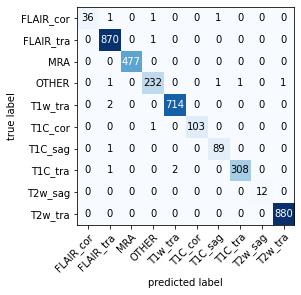

In [14]:
cf_matrix = confusion_matrix(y_nohot, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cf_matrix,
                                colorbar=False,
                                show_absolute=True,
                                show_normed=False,
                                class_names=classes,
                                )

In [15]:
# cal precision, recall, f1-score
metrics = classification_report(y_nohot, y_pred, target_names=classes, digits=3)

In [16]:
print(metrics)

              precision    recall  f1-score   support

   FLAIR_cor      1.000     0.923     0.960        39
   FLAIR_tra      0.993     0.999     0.996       871
         MRA      1.000     1.000     1.000       477
       OTHER      0.987     0.983     0.985       236
     T1w_tra      0.997     0.997     0.997       716
     T1C_cor      1.000     0.990     0.995       104
     T1C_sag      0.978     0.989     0.983        90
     T1C_tra      0.997     0.990     0.994       311
     T2w_sag      1.000     1.000     1.000        12
     T2w_tra      0.999     1.000     0.999       880

    accuracy                          0.996      3736
   macro avg      0.995     0.987     0.991      3736
weighted avg      0.996     0.996     0.996      3736

